<a href="https://colab.research.google.com/github/grace3999/USV_Python/blob/colab/Notebooks/4_xr_Annotations_classification_PSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mount google drive containings required files: 1) csv of annotation features, 2) netcdf files
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install netcdf4

In [3]:
!pip install seaborn==0.9.0

In [0]:
import numpy as np
import pandas as pd
import xarray as xr
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_val_predict, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
from sklearn.utils import resample

#visualizing results
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

In [0]:
features_path_CPA = '/content/gdrive/Shared drives/USV_eScience_Incubator/Data/feature_data_frames/annot_psd_100noise_CPA.csv'
features_path_neutral = '/content/gdrive/Shared drives/USV_eScience_Incubator/Data/feature_data_frames/annot_psd_100noise_neutral.csv'
features_path = [features_path_CPA, features_path_neutral]

In [10]:
annot_features_df = pd.DataFrame()

#Read in data frame of annotation features
for path in features_path:
  data = pd.read_csv(path)
  annot_features = pd.DataFrame(data = data)
  print(annot_features.shape)
  #check for missing values
  if annot_features.isnull().sum().sum() > 0:
    print('You have missing values in your data frame')
  else:
    print('Your data frame is complete')
  
  annot_features_df = annot_features_df.append(annot_features)

annot_features_df.replace('low ', 'low', inplace=True)
annot_features_df.replace('BBC', 'bbc', inplace=True)
print(annot_features_df.shape)
annot_features_df.head()

(2925, 263)
Your data frame is complete
(1803, 263)
Your data frame is complete
(4728, 263)


,Unnamed: 0,key_0,animal_number,session,time_stamp,Annotation,0.0,0.48828125,0.9765625,1.46484375,1.953125,2.44140625,2.9296875,3.41796875,3.90625,4.39453125,4.8828125,5.37109375,5.859375,6.34765625,6.8359375,7.32421875,7.8125,8.30078125,8.7890625,9.27734375,9.765625,10.25390625,10.7421875,11.23046875,11.71875,12.20703125,12.6953125,13.18359375,13.671875,14.16015625,14.6484375,15.13671875,15.625,16.11328125,16.6015625,17.08984375,17.578125,18.06640625,18.5546875,19.04296875,19.53125,20.01953125,20.5078125,20.99609375,21.484375,21.97265625,22.4609375,22.94921875,23.4375,23.92578125,24.4140625,24.90234375,25.390625,25.87890625,26.3671875,26.85546875,27.34375,27.83203125,28.3203125,28.80859375,29.296875,29.78515625,30.2734375,30.76171875,31.25,31.73828125,32.2265625,32.71484375,33.203125,33.69140625,34.1796875,34.66796875,35.15625,35.64453125,36.1328125,36.62109375,37.109375,37.59765625,38.0859375,38.57421875,39.0625,39.55078125,40.0390625,40.52734375,41.015625,41.50390625,41.9921875,42.48046875,42.96875,43.45703125,43.9453125,44.43359375,44.921875,45.41015625,45.8984375,46.38671875,46.875,47.36328125,47.8515625,48.33984375,48.828125,49.31640625,49.8046875,50.29296875,50.78125,51.26953125,51.7578125,52.24609375,52.734375,53.22265625,53.7109375,54.19921875,54.6875,55.17578125,55.6640625,56.15234375,56.640625,57.12890625,57.6171875,58.10546875,58.59375,59.08203125,59.5703125,60.05859375,60.546875,61.03515625,61.5234375,62.01171875,62.5,62.98828125,63.4765625,63.96484375,64.453125,64.94140625,65.4296875,65.91796875,66.40625,66.89453125,67.3828125,67.87109375,68.359375,68.84765625,69.3359375,69.82421875,70.3125,70.80078125,71.2890625,71.77734375,72.265625,72.75390625,73.2421875,73.73046875,74.21875,74.70703125,75.1953125,75.68359375,76.171875,76.66015625,77.1484375,77.63671875,78.125,78.61328125,79.1015625,79.58984375,80.078125,80.56640625,81.0546875,81.54296875,82.03125,82.51953125,83.0078125,83.49609375,83.984375,84.47265625,84.9609375,85.44921875,85.9375,86.42578125,86.9140625,87.40234375,87.890625,88.37890625,88.8671875,89.35546875,89.84375,90.33203125,90.8203125,91.30859375,91.796875,92.28515625,92.7734375,93.26171875,93.75,94.23828125,94.7265625,95.21484375,95.703125,96.19140625,96.6796875,97.16796875,97.65625,98.14453125,98.6328125,99.12109375,99.609375,100.09765625,100.5859375,101.07421875,101.5625,102.05078125,102.5390625,103.02734375,103.515625,104.00390625,104.4921875,104.98046875,105.46875,105.95703125,106.4453125,106.93359375,107.421875,107.91015625,108.3984375,108.88671875,109.375,109.86328125,110.3515625,110.83984375,111.328125,111.81640625,112.3046875,112.79296875,113.28125,113.76953125,114.2578125,114.74609375,115.234375,115.72265625,116.2109375,116.69921875,117.1875,117.67578125,118.1640625,118.65234375,119.140625,119.62890625,120.1171875,120.60546875,121.09375,121.58203125,122.0703125,122.55859375,123.046875,123.53515625,124.0234375,124.51171875,125.0
0,0,370080.0,625,CPApost,370080.0,bbc,646.76730,1261.7023,1221.0288,1249.1912,1334.5118,1448.7940,1717.1549,2375.2370,3468.7000,4710.4470,5851.8160,7249.169,9891.667,14716.1700,21942.363,31117.465,41509.180,51955.773,60253.703,63366.902,59189.883,48560.980,35310.656,23875.732,16559.610,12830.641,10814.135,9092.0380,7258.7803,5448.0522,3880.602,2795.5935,2373.3538,2489.8938,2683.0774,2539.3215,2091.1843,1739.9015,1816.4441,2314.9924,3046.5800,3940.8992,5136.1700,6811.9067,8961.11000,11276.7670,13221.46600,14268.21900,14186.2930,13151.8720,11571.89500,9784.1630,7921.1280,6023.72850,4210.70170,2689.99300,1624.58740,1023.73480,759.86540,662.96430,604.72174,537.73380,489.45135,515.41437,642.61456,856.46686,1140.22290,1503.10120,1944.93350,2402.67600,2767.53470,2971.02930,3032.49600,2998.80800,2852.58250,2519.37260,1981.33750,1359.77220,853.83180,589.81134,535.89386,556.136600,529.2252,418.819640,267.79280,164.648590,213.80191,494.35380,1002.981300,1625.19840,2178.102800,2501.62300,2526.63700,2278.46340,1840.07980,1319.26830,828.864600,461.60922,258.364070,195.89561,211.479

In [11]:
annot_features_df.dropna(axis=0, inplace=True)
annot_features_df['Annotation'].value_counts()

rand_noise     4300
low             162
bbc             140
low multi        50
high             48
low complex      23
high multi        5
Name: Annotation, dtype: int64

In [12]:
annot_features_df.groupby('Annotation').mean()

,Unnamed: 0,key_0,animal_number,time_stamp,0.0,0.48828125,0.9765625,1.46484375,1.953125,2.44140625,2.9296875,3.41796875,3.90625,4.39453125,4.8828125,5.37109375,5.859375,6.34765625,6.8359375,7.32421875,7.8125,8.30078125,8.7890625,9.27734375,9.765625,10.25390625,10.7421875,11.23046875,11.71875,12.20703125,12.6953125,13.18359375,13.671875,14.16015625,14.6484375,15.13671875,15.625,16.11328125,16.6015625,17.08984375,17.578125,18.06640625,18.5546875,19.04296875,19.53125,20.01953125,20.5078125,20.99609375,21.484375,21.97265625,22.4609375,22.94921875,23.4375,23.92578125,24.4140625,24.90234375,25.390625,25.87890625,26.3671875,26.85546875,27.34375,27.83203125,28.3203125,28.80859375,29.296875,29.78515625,30.2734375,30.76171875,31.25,31.73828125,32.2265625,32.71484375,33.203125,33.69140625,34.1796875,34.66796875,35.15625,35.64453125,36.1328125,36.62109375,37.109375,37.59765625,38.0859375,38.57421875,39.0625,39.55078125,40.0390625,40.52734375,41.015625,41.50390625,41.9921875,42.48046875,42.96875,43.45703125,43.9453125,44.43359375,44.921875,45.41015625,45.8984375,46.38671875,46.875,47.36328125,47.8515625,48.33984375,48.828125,49.31640625,49.8046875,50.29296875,50.78125,51.26953125,51.7578125,52.24609375,52.734375,53.22265625,53.7109375,54.19921875,54.6875,55.17578125,55.6640625,56.15234375,56.640625,57.12890625,57.6171875,58.10546875,58.59375,59.08203125,59.5703125,60.05859375,60.546875,61.03515625,61.5234375,62.01171875,62.5,62.98828125,63.4765625,63.96484375,64.453125,64.94140625,65.4296875,65.91796875,66.40625,66.89453125,67.3828125,67.87109375,68.359375,68.84765625,69.3359375,69.82421875,70.3125,70.80078125,71.2890625,71.77734375,72.265625,72.75390625,73.2421875,73.73046875,74.21875,74.70703125,75.1953125,75.68359375,76.171875,76.66015625,77.1484375,77.63671875,78.125,78.61328125,79.1015625,79.58984375,80.078125,80.56640625,81.0546875,81.54296875,82.03125,82.51953125,83.0078125,83.49609375,83.984375,84.47265625,84.9609375,85.44921875,85.9375,86.42578125,86.9140625,87.40234375,87.890625,88.37890625,88.8671875,89.35546875,89.84375,90.33203125,90.8203125,91.30859375,91.796875,92.28515625,92.7734375,93.26171875,93.75,94.23828125,94.7265625,95.21484375,95.703125,96.19140625,96.6796875,97.16796875,97.65625,98.14453125,98.6328125,99.12109375,99.609375,100.09765625,100.5859375,101.07421875,101.5625,102.05078125,102.5390625,103.02734375,103.515625,104.00390625,104.4921875,104.98046875,105.46875,105.95703125,106.4453125,106.93359375,107.421875,107.91015625,108.3984375,108.88671875,109.375,109.86328125,110.3515625,110.83984375,111.328125,111.81640625,112.3046875,112.79296875,113.28125,113.76953125,114.2578125,114.74609375,115.234375,115.72265625,116.2109375,116.69921875,117.1875,117.67578125,118.1640625,118.65234375,119.140625,119.62890625,120.1171875,120.60546875,121.09375,121.58203125,122.0703125,122.55859375,123.046875,123.53515625,124.0234375,124.51171875,125.0
Annotation,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bbc,115.692857,243047.410714,602.142857,243047.410714,617.543818,1239.251083,1188.346106,1039.632136,963.593943,1209.467394,1757.772627,2295.404180,2686.270338,3314.955740,4643.681951,6425.108474,7885.371973,9253.952105,12942.832181,22205.255251,37611.265116,54718.202476,66003.631462,66071.954642,55574.856137,40320.264756,26690.518263,17712.447129,12740.497012,9817.884009,7758.562916,6366.725905,5599.502154,5133.713792,4674.716919,4312.813307,4386.096751,5040.295666,5982.363611,6644.672975,6587.148352,5809.132902,4736.026986,3896.499384,3563.429052,3662.499567,3977.809100,4383.373139,4856.701192,5338.425832,5682.647493,5778.609929,5670.557009,5508.025204,5389.306154,5288.079158,5126.867053,4879.422469,4581.332031,4269.069256,3947.314905,3620.501730,3330.677842,3142.229280,3086.573583,3126.623654,3176.001410,3153.279879,

In [13]:
#create class column (noise = 0, USV = 1)
annot_features_df['class'] = np.where(annot_features_df['Annotation']=='rand_noise', 0, 1)
annot_features_df['class'].value_counts()

0    4300
1     428
Name: class, dtype: int64

In [0]:
#separate and save for later testing dataset
train, test = train_test_split(annot_features_df, test_size=0.3, random_state=1, stratify = annot_features_df['Annotation'])

In [0]:
#upsample minority class (can skip this step if sufficient annotated samples)
majority_class = 'rand_noise'
train_maj = train[train['Annotation'] == majority_class]
train_min = train[train['Annotation'] != majority_class]

train_min_upsamples = resample(train_min, replace=True, n_samples = len(train_maj), random_state = 123)

train_upsamples = pd.concat([train_min_upsamples, train_maj])

print(train_upsamples['Annotation'].value_counts())

train_upsamples.head()

rand_noise     3008
low            1137
bbc             958
low multi       357
high            346
low complex     165
high multi       45
Name: Annotation, dtype: int64


,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll,class
30,30,533,CPApost,46305.0,low,32714.904,0.368722,40822.118664,14708.781584,4.407609,26.730238,0.000149,38781.012731,1
263,263,650,CPApost,459045.0,bbc,105216.586,0.123273,30667.703480,49107.784985,3.612741,13.088721,-0.001791,29134.318306,1
16,16,622,CPApost,233865.0,bbc,563046.500,0.043433,15182.935398,20404.219724,4.023005,16.306977,-0.001660,14423.788628,1
5,5,527,neutral,393052.5,bbc,112545.530,0.173507,35624.111974,36172.726413,2.605948,6.169392,-0.001406,33842.906376,1
243,243,655,CPApost,503280.0,bbc,27339.217,0.434798,43940.010650,4746.057856,-0.390923,0.647627,0.000965,41743.010118,1


In [15]:
#separate and save features for train and test sets
train_features = train.loc[:, '0.0':'125.0']
test_features = test.loc[:, '0.0':'125.0']
train_features.head()

,0.0,0.48828125,0.9765625,1.46484375,1.953125,2.44140625,2.9296875,3.41796875,3.90625,4.39453125,4.8828125,5.37109375,5.859375,6.34765625,6.8359375,7.32421875,7.8125,8.30078125,8.7890625,9.27734375,9.765625,10.25390625,10.7421875,11.23046875,11.71875,12.20703125,12.6953125,13.18359375,13.671875,14.16015625,14.6484375,15.13671875,15.625,16.11328125,16.6015625,17.08984375,17.578125,18.06640625,18.5546875,19.04296875,19.53125,20.01953125,20.5078125,20.99609375,21.484375,21.97265625,22.4609375,22.94921875,23.4375,23.92578125,24.4140625,24.90234375,25.390625,25.87890625,26.3671875,26.85546875,27.34375,27.83203125,28.3203125,28.80859375,29.296875,29.78515625,30.2734375,30.76171875,31.25,31.73828125,32.2265625,32.71484375,33.203125,33.69140625,34.1796875,34.66796875,35.15625,35.64453125,36.1328125,36.62109375,37.109375,37.59765625,38.0859375,38.57421875,39.0625,39.55078125,40.0390625,40.52734375,41.015625,41.50390625,41.9921875,42.48046875,42.96875,43.45703125,43.9453125,44.43359375,44.921875,45.41015625,45.8984375,46.38671875,46.875,47.36328125,47.8515625,48.33984375,48.828125,49.31640625,49.8046875,50.29296875,50.78125,51.26953125,51.7578125,52.24609375,52.734375,53.22265625,53.7109375,54.19921875,54.6875,55.17578125,55.6640625,56.15234375,56.640625,57.12890625,57.6171875,58.10546875,58.59375,59.08203125,59.5703125,60.05859375,60.546875,61.03515625,61.5234375,62.01171875,62.5,62.98828125,63.4765625,63.96484375,64.453125,64.94140625,65.4296875,65.91796875,66.40625,66.89453125,67.3828125,67.87109375,68.359375,68.84765625,69.3359375,69.82421875,70.3125,70.80078125,71.2890625,71.77734375,72.265625,72.75390625,73.2421875,73.73046875,74.21875,74.70703125,75.1953125,75.68359375,76.171875,76.66015625,77.1484375,77.63671875,78.125,78.61328125,79.1015625,79.58984375,80.078125,80.56640625,81.0546875,81.54296875,82.03125,82.51953125,83.0078125,83.49609375,83.984375,84.47265625,84.9609375,85.44921875,85.9375,86.42578125,86.9140625,87.40234375,87.890625,88.37890625,88.8671875,89.35546875,89.84375,90.33203125,90.8203125,91.30859375,91.796875,92.28515625,92.7734375,93.26171875,93.75,94.23828125,94.7265625,95.21484375,95.703125,96.19140625,96.6796875,97.16796875,97.65625,98.14453125,98.6328125,99.12109375,99.609375,100.09765625,100.5859375,101.07421875,101.5625,102.05078125,102.5390625,103.02734375,103.515625,104.00390625,104.4921875,104.98046875,105.46875,105.95703125,106.4453125,106.93359375,107.421875,107.91015625,108.3984375,108.88671875,109.375,109.86328125,110.3515625,110.83984375,111.328125,111.81640625,112.3046875,112.79296875,113.28125,113.76953125,114.2578125,114.74609375,115.234375,115.72265625,116.2109375,116.69921875,117.1875,117.67578125,118.1640625,118.65234375,119.140625,119.62890625,120.1171875,120.60546875,121.09375,121.58203125,122.0703125,122.55859375,123.046875,123.53515625,124.0234375,124.51171875,125.0
27,565.376100,1179.122700,1178.788500,1004.604250,938.700500,1379.81050,2204.45680,2820.52660,3032.55030,3491.86000,4865.70260,6766.97200,8274.06600,9946.56200,14746.84700,25760.9340,42250.00800,58249.8000,66027.27000,61781.6100,48412.70300,32932.5400,21206.36500,14768.93200,11732.66300,9750.60300,7858.93460,6184.75900,4881.62060,3785.98070,2805.43210,2138.32900,1950.66410,2031.77500,1976.33060,1698.22770,1611.7677,2193.65900,3378.24410,4467.38870,4700.78120,3926.02930,2698.59230,1740.84010,1338.51340,1254.48350,1136.79530,901.38840,708.80023,678.34360,735.73840,734.97880,637.12054,516.82410,436.78470,381.84440,316.11856,249.61897,217.92100,222.27016,225.81203,206.72853,187.58057,201.80899,247.06853,285.85020,286.65890,252.84537,211.72568,185.66164,177.52136,177.03076,173.407360,162.330540,146.47874,132.613330,126.78998,129.95690,137.41965,142.88246,143.210020,139.57053,134.81750,130.57747,126.699295,122.403656,116.991516,109.644840,99.827340,88.96887,81.372475,81.79600,90.830635,102.97490,110.548195,110.137314,104.849495,100.187584,98.64291,98.934770,99.408910,100.220470,101.780900,102.747190,101.127640,96.98229,92.639500,90.0

In [16]:
#separate and save class labels for train and test sets
train_class = train['class']
test_class = test['class']
train_class.head()

27      1
1550    0
2109    0
1054    0
769     0
Name: class, dtype: int64

In [0]:
# center and scale the data for train and test sets
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.fit_transform(test_features)

In [0]:
#generate a 'groups' variable to use with stratified kfold
groups = train['Unnamed: 0'].values

group_k_fold = GroupKFold(n_splits=3)
cv = list(group_k_fold.split(train_features_scaled, train_class, groups))

In [0]:
#generate a 'groups' variable to use with stratified kfold

strat_k_fold = StratifiedKFold(n_splits=3)
cv = list(strat_k_fold.split(train_features_scaled, train_class))

In [0]:
lr_cv = LogisticRegression(random_state=0, class_weight='balanced')
rf_cv = RandomForestClassifier(max_depth=10, random_state=0, class_weight='balanced')
svm_cv = SVC(probability=True, class_weight='balanced') 

In [20]:
y_pred_lr = cross_val_predict(lr_cv, train_features_scaled, train_class, cv=cv, method='predict')
y_pred_prob_lr = cross_val_predict(lr_cv, train_features_scaled, train_class, cv=cv, method='predict_proba')
conf_mat_lr = confusion_matrix(train_class, y_pred_lr)
conf_mat_lr

array([[2637,  372],
       [ 119,  181]])

In [21]:
y_pred_rf = cross_val_predict(rf_cv, train_features_scaled, train_class, cv=cv, method='predict')
y_pred_prob_rf = cross_val_predict(rf_cv, train_features_scaled, train_class, cv=cv, method='predict_proba')
conf_mat_rf = confusion_matrix(train_class, y_pred_rf)
conf_mat_rf

array([[2944,   65],
       [ 196,  104]])

In [22]:
y_pred_svm = cross_val_predict(svm_cv, train_features_scaled, train_class, cv=cv, method='predict')
y_pred_prob_svm = cross_val_predict(svm_cv, train_features_scaled, train_class, cv=cv, method='predict_proba')
conf_mat_svm = confusion_matrix(train_class, y_pred_svm)
conf_mat_svm

array([[2953,   56],
       [ 151,  149]])

In [23]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(train_class,y_pred_lr))
print("Precision (PPV): ", metrics.precision_score(train_class,y_pred_lr))
print("Accuracy: ", metrics.accuracy_score(train_class,y_pred_lr))
print("F1:", metrics.f1_score(train_class,y_pred_lr))

Sensitivity/Recall (TPR):  0.6033333333333334
Precision (PPV):  0.32730560578661844
Accuracy:  0.8516168026594138
F1: 0.42438452520515824


In [24]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(train_class, y_pred_rf))
print("Precision (PPV): ", metrics.precision_score(train_class, y_pred_rf))
print("Accuracy: ", metrics.accuracy_score(train_class, y_pred_rf))
print("F1:", metrics.f1_score(train_class, y_pred_rf))

Sensitivity/Recall (TPR):  0.3466666666666667
Precision (PPV):  0.6153846153846154
Accuracy:  0.9211242067089755
F1: 0.44349680170575695


In [25]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(train_class,y_pred_svm))
print("Precision (PPV): ", metrics.precision_score(train_class,y_pred_svm))
print("Accuracy: ", metrics.accuracy_score(train_class,y_pred_svm))
print("F1:", metrics.f1_score(train_class,y_pred_svm))

Sensitivity/Recall (TPR):  0.49666666666666665
Precision (PPV):  0.7268292682926829
Accuracy:  0.9374433363553943
F1: 0.5900990099009901


In [26]:
print("Logistic regression ROC_AUC: ", metrics.roc_auc_score(train_class, y_pred_prob_lr[:,1]))
print("Random forest ROC_AUC: ", metrics.roc_auc_score(train_class, y_pred_prob_rf[:,1]))
print("SVM ROC_AUC: ", metrics.roc_auc_score(train_class, y_pred_prob_svm[:,1]))

Logistic regression ROC_AUC:  0.8010679073889442
Random forest ROC_AUC:  0.869749086075108
SVM ROC_AUC:  0.85484934086629


Text(0, 0.5, 'True Positive Rate (Sensitivity)')

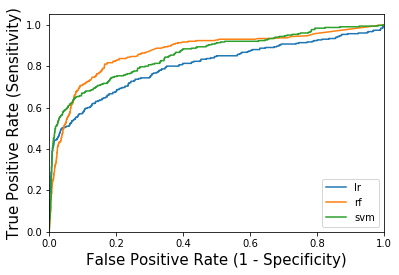

In [27]:
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(train_class, y_pred_prob_lr[:,1])
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(train_class, y_pred_prob_rf[:,1])
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(train_class, y_pred_prob_svm[:,1])
# plot LR model ROC curves
plt.plot(fpr_lr, tpr_lr,label="lr")
plt.plot(fpr_rf, tpr_rf,label="rf")
plt.plot(fpr_svm, tpr_svm,label="svm")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize = 15)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize = 15)

Text(0, 0.5, 'Precision')

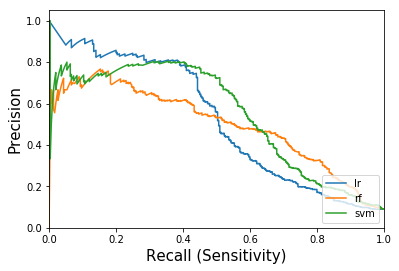

In [28]:
# calculate precision-recall curve
precision_lr, recall_lr, thresholds_pr_lr = metrics.precision_recall_curve(train_class, y_pred_prob_lr[:,1])
precision_rf, recall_rf, thresholds_pr_rf = metrics.precision_recall_curve(train_class, y_pred_prob_rf[:,1])
precision_svm, recall_svm, thresholds_pr_svm = metrics.precision_recall_curve(train_class, y_pred_prob_svm[:,1])

plt.plot(recall_lr, precision_lr, label='lr')
plt.plot(recall_rf, precision_rf, label='rf')
plt.plot(recall_svm, precision_svm, label='svm')

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('Recall (Sensitivity)', fontsize = 15)
plt.ylabel('Precision', fontsize = 15)

Text(0, 0.5, 'True Positive Rate (Sensitivity) or Class 1 Threshold Probability')

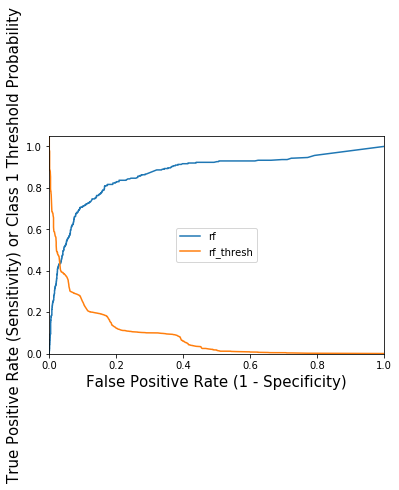

In [29]:
# plot best model with thresholds
plt.plot(fpr_rf, tpr_rf, label="rf")
plt.plot(fpr_rf, thresholds_rf, label="rf_thresh")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="center")
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize= 15)
plt.ylabel('True Positive Rate (Sensitivity) or Class 1 Threshold Probability', fontsize = 15)

In [30]:
#create new columns for each model's pred prob and the best model's pred class
train['pred_prob_lr'] = y_pred_prob_lr[:,1]
train['pred_prob_rf'] = y_pred_prob_rf[:,1]
train['pred_prob_svm'] = y_pred_prob_svm[:,1]
train['class_rf'] = y_pred_rf
train['class_svm'] = y_pred_svm
train.head()

,Unnamed: 0,key_0,animal_number,session,time_stamp,Annotation,0.0,0.48828125,0.9765625,1.46484375,1.953125,2.44140625,2.9296875,3.41796875,3.90625,4.39453125,4.8828125,5.37109375,5.859375,6.34765625,6.8359375,7.32421875,7.8125,8.30078125,8.7890625,9.27734375,9.765625,10.25390625,10.7421875,11.23046875,11.71875,12.20703125,12.6953125,13.18359375,13.671875,14.16015625,14.6484375,15.13671875,15.625,16.11328125,16.6015625,17.08984375,17.578125,18.06640625,18.5546875,19.04296875,19.53125,20.01953125,20.5078125,20.99609375,21.484375,21.97265625,22.4609375,22.94921875,23.4375,23.92578125,24.4140625,24.90234375,25.390625,25.87890625,26.3671875,26.85546875,27.34375,27.83203125,28.3203125,28.80859375,29.296875,29.78515625,30.2734375,30.76171875,31.25,31.73828125,32.2265625,32.71484375,33.203125,33.69140625,34.1796875,34.66796875,35.15625,35.64453125,36.1328125,36.62109375,37.109375,37.59765625,38.0859375,38.57421875,39.0625,39.55078125,40.0390625,40.52734375,41.015625,41.50390625,41.9921875,42.48046875,42.96875,43.45703125,43.9453125,44.43359375,44.921875,45.41015625,45.8984375,46.38671875,46.875,47.36328125,47.8515625,48.33984375,48.828125,49.31640625,49.8046875,50.29296875,50.78125,51.26953125,51.7578125,52.24609375,52.734375,53.22265625,53.7109375,54.19921875,54.6875,55.17578125,55.6640625,56.15234375,56.640625,57.12890625,57.6171875,58.10546875,58.59375,59.08203125,59.5703125,60.05859375,60.546875,61.03515625,61.5234375,62.01171875,62.5,62.98828125,63.4765625,63.96484375,64.453125,64.94140625,65.4296875,65.91796875,66.40625,66.89453125,67.3828125,67.87109375,68.359375,68.84765625,69.3359375,69.82421875,70.3125,70.80078125,71.2890625,71.77734375,72.265625,72.75390625,73.2421875,73.73046875,74.21875,74.70703125,75.1953125,75.68359375,76.171875,76.66015625,77.1484375,77.63671875,78.125,78.61328125,79.1015625,79.58984375,80.078125,80.56640625,81.0546875,81.54296875,82.03125,82.51953125,83.0078125,83.49609375,83.984375,84.47265625,84.9609375,85.44921875,85.9375,86.42578125,86.9140625,87.40234375,87.890625,88.37890625,88.8671875,89.35546875,89.84375,90.33203125,90.8203125,91.30859375,91.796875,92.28515625,92.7734375,93.26171875,93.75,94.23828125,94.7265625,95.21484375,95.703125,96.19140625,96.6796875,97.16796875,97.65625,98.14453125,98.6328125,99.12109375,99.609375,100.09765625,100.5859375,101.07421875,101.5625,102.05078125,102.5390625,103.02734375,103.515625,104.00390625,104.4921875,104.98046875,105.46875,105.95703125,106.4453125,106.93359375,107.421875,107.91015625,108.3984375,108.88671875,109.375,109.86328125,110.3515625,110.83984375,111.328125,111.81640625,112.3046875,112.79296875,113.28125,113.76953125,114.2578125,114.74609375,115.234375,115.72265625,116.2109375,116.69921875,117.1875,117.67578125,118.1640625,118.65234375,119.140625,119.62890625,120.1171875,120.60546875,121.09375,121.58203125,122.0703125,122.55859375,123.046875,123.53515625,124.0234375,124.51171875,125.0,class,pred_prob_lr,pred_prob_rf,pred_prob_svm,class_rf,class_svm
27,27,307800.0,624,CPApost,307800.0,bbc,565.376100,1179.122700,1178.788500,1004.604250,938.700500,1379.81050,2204.45680,2820.52660,3032.55030,3491.86000,4865.70260,6766.97200,8274.06600,9946.56200,14746.84700,25760.9340,42250.00800,58249.8000,66027.27000,61781.6100,48412.70300,32932.5400,21206.36500,14768.93200,11732.66300,9750.60300,7858.93460,6184.75900,4881.62060,3785.98070,2805.43210,2138.32900,1950.66410,2031.77500,1976.33060,1698.22770,1611.7677,2193.65900,3378.24410,4467.38870,4700.78120,3926.02930,2698.59230,1740.84010,1338.51340,1254.48350,1136.79530,901.38840,708.80023,678.34360,735.73840,734.97880,637.12054,516.82410,436.78470,381.84440,316.11856,249.61897,217.92100,222.27016,225.81203,206.72853,187.58057,201.80899,247.06853,285.85020,286.65890,252.84537,211.72568,185.66164,177.52136,177.03076,173.407360,162.330540,146.47874,132.613330,126.78998,129.95690,137.41965,142.88246,143.210020,139.57053,134.81750,130.57747,126.699295,122.403656,116.991516,109.644840,99.827340,88.96887,81.372475,81.796

In [0]:
#create a predictions column for subesquent viz of TN, TP, FN, FP
def conf_mat_column(dataframe, model_name):
  preds = []
  for index, row in dataframe.iterrows():
      if (row['class'] == 0) & (row[model_name] == 0):
          pred = 'TN'
      if (row['class'] == 0) & (row[model_name] == 1):
          pred = 'FP'
      if (row['class'] == 1) & (row[model_name] == 1):
          pred = 'TP'
      if (row['class'] == 1) & (row[model_name] == 0):
          pred = 'FN'
          
      preds.append(pred)
      
  dataframe[str('pred_' + model_name)] = preds
  return dataframe

In [32]:
#create a predictions column for subesquent viz of TN, TP, FN, FP
model_name = 'class_rf'
train = conf_mat_column(train, model_name)
model_name = 'class_svm'
train = conf_mat_column(train, model_name)
train.head()

,Unnamed: 0,key_0,animal_number,session,time_stamp,Annotation,0.0,0.48828125,0.9765625,1.46484375,1.953125,2.44140625,2.9296875,3.41796875,3.90625,4.39453125,4.8828125,5.37109375,5.859375,6.34765625,6.8359375,7.32421875,7.8125,8.30078125,8.7890625,9.27734375,9.765625,10.25390625,10.7421875,11.23046875,11.71875,12.20703125,12.6953125,13.18359375,13.671875,14.16015625,14.6484375,15.13671875,15.625,16.11328125,16.6015625,17.08984375,17.578125,18.06640625,18.5546875,19.04296875,19.53125,20.01953125,20.5078125,20.99609375,21.484375,21.97265625,22.4609375,22.94921875,23.4375,23.92578125,24.4140625,24.90234375,25.390625,25.87890625,26.3671875,26.85546875,27.34375,27.83203125,28.3203125,28.80859375,29.296875,29.78515625,30.2734375,30.76171875,31.25,31.73828125,32.2265625,32.71484375,33.203125,33.69140625,34.1796875,34.66796875,35.15625,35.64453125,36.1328125,36.62109375,37.109375,37.59765625,38.0859375,38.57421875,39.0625,39.55078125,40.0390625,40.52734375,41.015625,41.50390625,41.9921875,42.48046875,42.96875,43.45703125,43.9453125,44.43359375,44.921875,45.41015625,45.8984375,46.38671875,46.875,47.36328125,47.8515625,48.33984375,48.828125,49.31640625,49.8046875,50.29296875,50.78125,51.26953125,51.7578125,52.24609375,52.734375,53.22265625,53.7109375,54.19921875,54.6875,55.17578125,55.6640625,56.15234375,56.640625,57.12890625,57.6171875,58.10546875,58.59375,59.08203125,59.5703125,60.05859375,60.546875,61.03515625,61.5234375,62.01171875,62.5,62.98828125,63.4765625,63.96484375,64.453125,64.94140625,65.4296875,65.91796875,66.40625,66.89453125,67.3828125,67.87109375,68.359375,68.84765625,69.3359375,69.82421875,70.3125,70.80078125,71.2890625,71.77734375,72.265625,72.75390625,73.2421875,73.73046875,74.21875,74.70703125,75.1953125,75.68359375,76.171875,76.66015625,77.1484375,77.63671875,78.125,78.61328125,79.1015625,79.58984375,80.078125,80.56640625,81.0546875,81.54296875,82.03125,82.51953125,83.0078125,83.49609375,83.984375,84.47265625,84.9609375,85.44921875,85.9375,86.42578125,86.9140625,87.40234375,87.890625,88.37890625,88.8671875,89.35546875,89.84375,90.33203125,90.8203125,91.30859375,91.796875,92.28515625,92.7734375,93.26171875,93.75,94.23828125,94.7265625,95.21484375,95.703125,96.19140625,96.6796875,97.16796875,97.65625,98.14453125,98.6328125,99.12109375,99.609375,100.09765625,100.5859375,101.07421875,101.5625,102.05078125,102.5390625,103.02734375,103.515625,104.00390625,104.4921875,104.98046875,105.46875,105.95703125,106.4453125,106.93359375,107.421875,107.91015625,108.3984375,108.88671875,109.375,109.86328125,110.3515625,110.83984375,111.328125,111.81640625,112.3046875,112.79296875,113.28125,113.76953125,114.2578125,114.74609375,115.234375,115.72265625,116.2109375,116.69921875,117.1875,117.67578125,118.1640625,118.65234375,119.140625,119.62890625,120.1171875,120.60546875,121.09375,121.58203125,122.0703125,122.55859375,123.046875,123.53515625,124.0234375,124.51171875,125.0,class,pred_prob_lr,pred_prob_rf,pred_prob_svm,class_rf,class_svm,pred_class_rf,pred_class_svm
27,27,307800.0,624,CPApost,307800.0,bbc,565.376100,1179.122700,1178.788500,1004.604250,938.700500,1379.81050,2204.45680,2820.52660,3032.55030,3491.86000,4865.70260,6766.97200,8274.06600,9946.56200,14746.84700,25760.9340,42250.00800,58249.8000,66027.27000,61781.6100,48412.70300,32932.5400,21206.36500,14768.93200,11732.66300,9750.60300,7858.93460,6184.75900,4881.62060,3785.98070,2805.43210,2138.32900,1950.66410,2031.77500,1976.33060,1698.22770,1611.7677,2193.65900,3378.24410,4467.38870,4700.78120,3926.02930,2698.59230,1740.84010,1338.51340,1254.48350,1136.79530,901.38840,708.80023,678.34360,735.73840,734.97880,637.12054,516.82410,436.78470,381.84440,316.11856,249.61897,217.92100,222.27016,225.81203,206.72853,187.58057,201.80899,247.06853,285.85020,286.65890,252.84537,211.72568,185.66164,177.52136,177.03076,173.407360,162.330540,146.47874,132.613330,126.78998,129.95690,137.41965,142.88246,143.210020,139.57053,134.81750,130.57747,126.699295,122.403656,116.991516,109.644840,99.827

In [34]:
train.groupby('Annotation')['pred_class_rf'].value_counts()

Annotation   pred_class_rf
bbc          TP                 57
             FN                 41
high         FN                 25
             TP                  9
high multi   FN                  3
             TP                  1
low          FN                 98
             TP                 15
low complex  FN                 10
             TP                  6
low multi    FN                 19
             TP                 16
rand_noise   TN               2944
             FP                 65
Name: pred_class_rf, dtype: int64

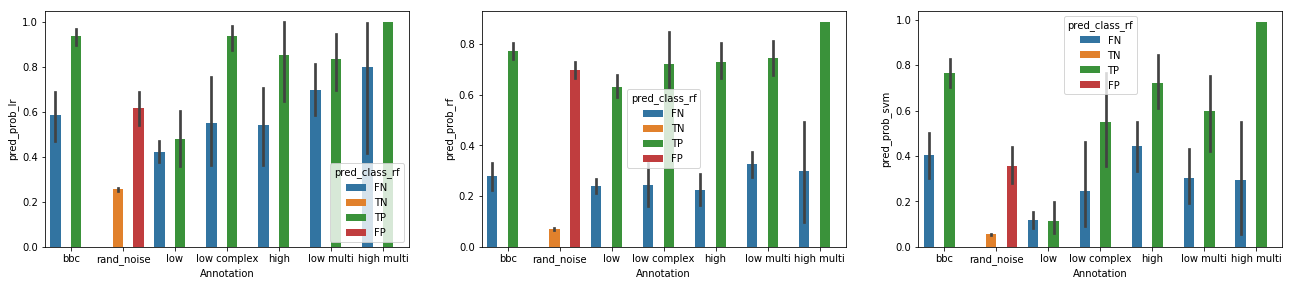

In [37]:
#viz of feature vs. pred group
feat_col = train.loc[:, 'pred_prob_lr':'pred_prob_svm']

i=1
plt.figure(figsize=(30,20))
for name in feat_col:
    plt.subplot(4, 4, i)
    sns.barplot(x="Annotation", y=name, hue="pred_class_rf", data=train)
    i = i + 1

In [0]:
#viz for false negatives (need path for corresponding netcdf files)
netcdf_path = '/content/gdrive/Shared drives/USV_eScience_Incubator/Data/netcdf_files/CPA'
false_neg_unique = train_upsamples[train_upsamples['pred'] == 'FN'].drop_duplicates()
dim = dim = np.int(np.ceil(np.sqrt(false_neg_unique.shape[0])))
i = 1
plt.figure(figsize=(dim*5,dim*5))
for index, row in false_neg_unique.iterrows():
  data = xr.open_dataset(str(netcdf_path + '/' + row['animal_number'] + '_' + row['session'] + '_xr_Dataset.nc'))
    
  data_slice = data['__xarray_dataarray_variable__'].sel(slices=row['time_stamp'])
  times = data['times'].values
  freqs = data['freq'].values
    
  max_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).max(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
  #min_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).min(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    
  plt.subplot(dim, dim, i)
  xr.ufuncs.log(data_slice).plot(cmap='magma', vmin=0, vmax = max_value*.7)
    
  i = i + 1

TypeError: ignored

<Figure size 1080x1080 with 0 Axes>

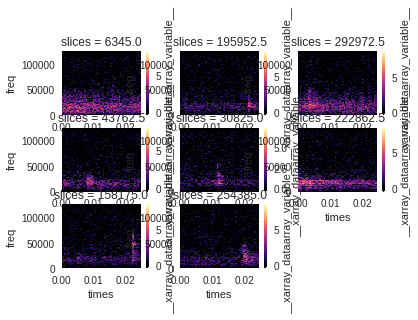

In [0]:
#viz for false positives (need path for corresponding netcdf files)
netcdf_path_pain = '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Pain'
false_pos_unique = train_upsamples[train_upsamples['pred'] == 'FP'].drop_duplicates()
dim = dim = np.int(np.ceil(np.sqrt(false_pos_unique.shape[0])))
i = 1
plt.figure(figsize=(dim*5,dim*5))
for index, row in false_pos_unique.iterrows():
    data = xr.open_dataset(str(netcdf_path_pain + '/' + row['session'] + '-' + row['animal_number'] + '-Pre_xr_Dataset.nc'))
    
    data_slice = data['__xarray_dataarray_variable__'].sel(slices=row['time_stamp'])
    times = data['times'].values
    freqs = data['freq'].values
    
    max_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).max(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    #min_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).min(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    
    plt.subplot(dim, dim, i)
    xr.ufuncs.log(data_slice).plot(cmap='magma', vmin=0, vmax = max_value*.7)
    
    i = i + 1

In [38]:
#once you have decided on the model and hyperparameters, fit the model using the train data
rf_cv.fit(train_features_scaled, train_class) 
svm_cv.fit(train_features_scaled, train_class) 

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [39]:
#test model using test data and theshold of 0.5
print(rf_cv.score(test_features_scaled, test_class))
test_pred_rf = rf_cv.predict(test_features_scaled)
test_pred_prob_rf = rf_cv.predict_proba(test_features_scaled)
print(classification_report(test_class, test_pred_rf))
confusion_matrix(test_class, test_pred_rf)

0.8780831571529246
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      1291
           1       0.22      0.13      0.16       128

    accuracy                           0.88      1419
   macro avg       0.57      0.54      0.55      1419
weighted avg       0.85      0.88      0.86      1419



array([[1229,   62],
       [ 111,   17]])

In [40]:
#test model using test data and theshold of 0.5
print(svm_cv.score(test_features_scaled, test_class))
test_pred_svm = svm_cv.predict(test_features_scaled)
test_pred_prob_svm = svm_cv.predict_proba(test_features_scaled)
print(classification_report(test_class, test_pred_svm))
confusion_matrix(test_class, test_pred_svm)

0.8611698379140239
              precision    recall  f1-score   support

           0       0.96      0.88      0.92      1291
           1       0.35      0.66      0.46       128

    accuracy                           0.86      1419
   macro avg       0.66      0.77      0.69      1419
weighted avg       0.91      0.86      0.88      1419



array([[1138,  153],
       [  44,   84]])

In [41]:
#create new column for model pred porb
test['pred_prob_rf'] = test_pred_prob_rf[:,1]
test['class_rf'] = test_pred_rf
test['pred_prob_svm'] = test_pred_prob_svm[:,1]
test['class_svm'] = test_pred_svm

#create a predictions column for subesquent viz of TN, TP, FN, FP
model_name = 'class_rf'
test = conf_mat_column(test, model_name)
model_name = 'class_svm'
test = conf_mat_column(test, model_name)
test.head()

,Unnamed: 0,key_0,animal_number,session,time_stamp,Annotation,0.0,0.48828125,0.9765625,1.46484375,1.953125,2.44140625,2.9296875,3.41796875,3.90625,4.39453125,4.8828125,5.37109375,5.859375,6.34765625,6.8359375,7.32421875,7.8125,8.30078125,8.7890625,9.27734375,9.765625,10.25390625,10.7421875,11.23046875,11.71875,12.20703125,12.6953125,13.18359375,13.671875,14.16015625,14.6484375,15.13671875,15.625,16.11328125,16.6015625,17.08984375,17.578125,18.06640625,18.5546875,19.04296875,19.53125,20.01953125,20.5078125,20.99609375,21.484375,21.97265625,22.4609375,22.94921875,23.4375,23.92578125,24.4140625,24.90234375,25.390625,25.87890625,26.3671875,26.85546875,27.34375,27.83203125,28.3203125,28.80859375,29.296875,29.78515625,30.2734375,30.76171875,31.25,31.73828125,32.2265625,32.71484375,33.203125,33.69140625,34.1796875,34.66796875,35.15625,35.64453125,36.1328125,36.62109375,37.109375,37.59765625,38.0859375,38.57421875,39.0625,39.55078125,40.0390625,40.52734375,41.015625,41.50390625,41.9921875,42.48046875,42.96875,43.45703125,43.9453125,44.43359375,44.921875,45.41015625,45.8984375,46.38671875,46.875,47.36328125,47.8515625,48.33984375,48.828125,49.31640625,49.8046875,50.29296875,50.78125,51.26953125,51.7578125,52.24609375,52.734375,53.22265625,53.7109375,54.19921875,54.6875,55.17578125,55.6640625,56.15234375,56.640625,57.12890625,57.6171875,58.10546875,58.59375,59.08203125,59.5703125,60.05859375,60.546875,61.03515625,61.5234375,62.01171875,62.5,62.98828125,63.4765625,63.96484375,64.453125,64.94140625,65.4296875,65.91796875,66.40625,66.89453125,67.3828125,67.87109375,68.359375,68.84765625,69.3359375,69.82421875,70.3125,70.80078125,71.2890625,71.77734375,72.265625,72.75390625,73.2421875,73.73046875,74.21875,74.70703125,75.1953125,75.68359375,76.171875,76.66015625,77.1484375,77.63671875,78.125,78.61328125,79.1015625,79.58984375,80.078125,80.56640625,81.0546875,81.54296875,82.03125,82.51953125,83.0078125,83.49609375,83.984375,84.47265625,84.9609375,85.44921875,85.9375,86.42578125,86.9140625,87.40234375,87.890625,88.37890625,88.8671875,89.35546875,89.84375,90.33203125,90.8203125,91.30859375,91.796875,92.28515625,92.7734375,93.26171875,93.75,94.23828125,94.7265625,95.21484375,95.703125,96.19140625,96.6796875,97.16796875,97.65625,98.14453125,98.6328125,99.12109375,99.609375,100.09765625,100.5859375,101.07421875,101.5625,102.05078125,102.5390625,103.02734375,103.515625,104.00390625,104.4921875,104.98046875,105.46875,105.95703125,106.4453125,106.93359375,107.421875,107.91015625,108.3984375,108.88671875,109.375,109.86328125,110.3515625,110.83984375,111.328125,111.81640625,112.3046875,112.79296875,113.28125,113.76953125,114.2578125,114.74609375,115.234375,115.72265625,116.2109375,116.69921875,117.1875,117.67578125,118.1640625,118.65234375,119.140625,119.62890625,120.1171875,120.60546875,121.09375,121.58203125,122.0703125,122.55859375,123.046875,123.53515625,124.0234375,124.51171875,125.0,class,pred_prob_rf,class_rf,pred_prob_svm,class_svm,pred_class_rf,pred_class_svm
152,49,204975.0,527,neutral,204975.0,rand_noise,22.270145,103.285150,274.30050,534.391200,831.873840,1094.457200,1258.32570,1295.998800,1221.34390,1077.39860,927.44183,847.76740,897.13885,1063.37050,1240.87000,1290.70090,1150.1820,886.6253,634.1499,477.1554,400.3429,342.98315,278.0816,226.68259,211.32974,221.49153,230.25366,228.78499,231.31487,251.26553,283.83320,312.75020,326.04654,321.93380,304.89870,281.50388,258.41898,239.81107,225.17310,211.20625,196.31685,182.32265,172.01419,166.68225,166.21797,169.42053,172.52782,169.10054,155.01343,135.26773,123.74406,132.40723,158.85667,185.74756,194.75336,181.98793,159.47163,142.24754,136.10309,138.27788,146.64366,163.21979,187.38474,209.38841,215.13951,198.47585,167.09375,135.86330,115.72577,109.299706,114.080734,125.87203,138.67640,145.05270,140.62668,128.88417,119.360530,119.32202,127.34451,135.76366,139.05421,138.76178,140.17833,145.537120,151.631500,153.62517,149.78726,142.130940,133.646800,126.08157,119.955650,115.311910,111.88139,109.2021

In [42]:
test.groupby('Annotation')['pred_class_svm'].value_counts()

Annotation   pred_class_svm
bbc          TP                  37
             FN                   5
high         TP                  12
             FN                   2
high multi   TP                   1
low          FN                  34
             TP                  15
low complex  TP                   6
             FN                   1
low multi    TP                  13
             FN                   2
rand_noise   TN                1138
             FP                 153
Name: pred_class_svm, dtype: int64

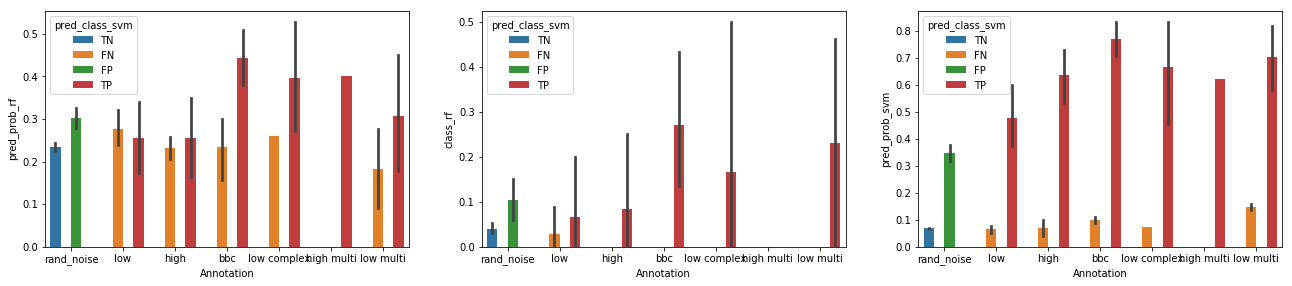

In [45]:
#viz of feature vs. pred group
feat_col = test.loc[:, 'pred_prob_rf':'pred_prob_svm']

i=1
plt.figure(figsize=(30,20))
for name in feat_col:
    plt.subplot(4, 4, i)
    sns.barplot(x="Annotation", y=name, hue="pred_class_svm", data=test)
    i = i + 1

In [0]:
#pickel model to save for later use
save_path = '/content/gdrive/Shared drives/USV_eScience_Incubator/Data/pickled_models/'


pkl_filename = str(save_path + "trained_pickle_model_psd_rf_strat_noup.pkl")  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(rf_cv, file)

In [0]:
#pickel model to save for later use
save_path = '/content/gdrive/Shared drives/USV_eScience_Incubator/Data/pickled_models/'


pkl_filename = str(save_path + "trained_pickle_model_psd_svm_strat_noup.pkl")  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(svm_cv, file)

In [0]:
%%time
# This function can take a long to run
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,  perplexity=50.0, n_iter=5000)
tsne_features = tsne.fit_transform(train_features_scaled)

In [0]:
print(tsne_features.shape)
tsne_df = pd.DataFrame(data = tsne_features, columns = ['tsne_0', 'tsne_1'], index = train['Unnamed: 0'])
tsne_df['label'] = train['class'].values
tsne_df['session'] = train['session'].values
tsne_df['Annotation'] = train['Annotation'].values
tsne_df.head()

In [0]:
plt.figure(figsize=(7,7))
sns.scatterplot(x = 'tsne_0', y = 'tsne_1', hue = 'Annotation', data = tsne_df)
plt.title("Projection of the data on 2 components + ground truth labels")